# More bandwidth selectors

## Introduction

Recall the Asymptotic Mean Integrated Squared Error and the bandwidth $h$ that minimizes it: 

$$
\text{AMISE} = \frac{1}{4} h^4 R(f'') + \frac{1}{2N\sqrt{\pi}h}
\tag{3.1}
$$

$$
h_{\text{AMISE}} = \left(\frac{1}{2N\sqrt{\pi} R(f'')} \right)^{1 / 5}
\tag{3.2}
$$

The **Gaussian rule of thumb** to estimate $h$ is derived under the assumption that $f$ is a Gaussian density. Despite the criticism at a conceptual level it is indeed a useful rule in many practical situations. But its simplicity does not come at a free cost. When the true $f$ differs seriously from a Gaussian distribution, the Gaussian KDE with bandwidth estimated by either Scotts' or Silverman's rule results in a poor alternative.

It can be seen the optimal $h$ depends on $R(f'') = \int{[f''(x)]^2 dx}$, which is a measure of how wiggly $f$ is. AMISE formula tells that higher values of $R(f'')$ result in higher bias. More sinuous densities are more difficult to estimate.

The more $f$ differs from a normal distribution in terms of roughness, the worse the gaussian rule of thumb is. If the density we are trying to estimate has peaks and/or multiple modes, the estimation will oversmooth the true distribution. Particularly, the problem is that we are replacing the true $R(f'')$ with $R(g_{\text{gaussian}}'')$ when actually $R(f'') \gg R(g_{\text{gaussian}}'')$.

In the paper *A brief survey on bandwidth selection for density estimation*, Jones, Marron and Sheather (1996) studied the Monte Carlo performance of the normal reference bandwidth based on the 
standard deviation, that is, they considered $h = 1.06\hat{\sigma}N^{-0.2}$. 
They found that $h$ had a mean that was usually unacceptably large and thus often produced oversmoother density estimates. 

In [2]:
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import sys
sys.path.append('../src/')
from my_functions import convolution_kde, theta_kde

%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 7]

BLUE = "#3498db"
DARK_BLUE = "#2980b9"
NIGHT_BLUE = "#2c3e50"

The following code generates 50 samples of size 3000 from a mixture of Gaussian distributions with variable mean and standard deviation. It can be seen that while the estimator has low variance, it has high bias.  
The density to be estimated is more sinuous than a Gaussian, and consequently, the estimator oversmooths the true $f$. We can appreciate the estimator puts more the density when it is actually very low and it fails to detect the two modes on the left part of the plot.

For some applications, the result could still be good enough, as we can see the general pattern of the underlying distribution. For other applications where it is desired to obtain an accurate estimation of the modes, the result is unsastifactory.

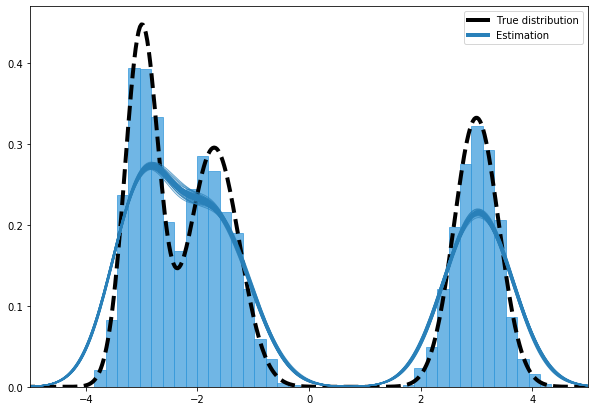

In [3]:
def generate_rvs(n, mean, sd):
    assert len(mean) == len(sd)
    x = np.concatenate((
        list(map(lambda m, s: stats.norm.rvs(m, s, int(n / len(mean))), mean, sd))
    ))
    return x

def get_pdf(x_grid, mean, sd):
    assert len(mean) == len(sd)
    pdf = (1 / len(mean)) * np.sum(list((map(lambda m, s: stats.norm.pdf(x_grid, m, s), mean, sd))), axis=0)
    return pdf

np.random.seed(1234)
x_grid = np.linspace(-6, 7, 500)
mean = [-3, -1.7, 3]
sd = [0.3, 0.45, 0.4]
n = 3000
reps = 50

colors = ["black", DARK_BLUE]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]
labels = ["True distribution", "Estimation"]

pdf_true = get_pdf(x_grid, mean, sd)
plt.plot(x_grid, pdf_true, linewidth=4, linestyle="--", color="black")

for i in range(reps):
    rvs = generate_rvs(n, mean, sd)
    x_kde, y_kde = convolution_kde(rvs)
    plt.plot(x_kde, y_kde, linewidth=1, color=DARK_BLUE, alpha=0.7)

plt.hist(rvs, density=True, bins=40, alpha=0.7, Color=BLUE)
plt.xlim(-5, 5)
plt.legend(lines, labels);

## 2. Alternative bandwidth selectors

Many alternative bandwidth selectors for the Gaussian KDE can be found in the literature. An outdated collection of such methods is *A brief survey on bandwidth selection for density estimation* (Jones, Marron and Sheather, 1996). I am not still aware of a similar, but updated, survey.

It is possible to classify bandwidth selection methods in (at least) three groups:

1. Rules of thumb
1. Cross-Validation
1. Plug-in Approach

### 1. Rules of thumb

This is the group where Scotts' and Silverman's rules of thumb fall. The basic idea is to replace the unknown part of $h_{\text{AMISE}}$, $R(f'')$, by an estimated value based on a parametric family. 

While location is not important when choosing a kernel, the scale parameter is. Because of this and its simplicity is that a Gaussian distribution with mean 0 and standard deviation $\sigma$ is chosen.

### 2. Cross-Validation

#### a. Least Squares Cross-Validation

The idea first appeared in *Empirical Choice of Histograms and Kernel density Estimators* (Rudemo, 1982) and *An Alternative Method of Cross-Validation for the Smoothing of Density Estimate* (Bowman, 1984).

It is possible to measure the closeness of $\hat{f}$ and $f$ for a given sample with the Integrated Squared Error (ISE).

$$
\text{ISE}(\hat{f}(x; h)) = \int{[\hat{f}(x; h) - f(x)]^2}dx
\tag{3.3}
$$

$$
  \begin{split}
    \text{ISE}(\hat{f}(x; h)) & = \int{[\hat{f}(x; h) - f(x)]^2}dx \\
     & = \int{[\hat{f}(x; h)]^2}dx - 2 \int{[\hat{f}(x; h)]^2f(x)}dx + \int{f^2(x)dx}
  \end{split}
  \tag{3.4}
$$

It can be noticed the last term of the expansion in (3.4) does not involve $h$. Bowman (1984) proposed choosing the bandwidth as the value of $h$ that minimizes the estimate of the two other terms

$$
\text{LSCV}(h) = \frac{1}{N} \sum_{i=1}^N{\int[\hat{f}_{-i}(x)]^2 dx} - \frac{2}{N} \sum_{i=1}^N{\hat{f}_{-i}(X_i)}
\tag{3.5}
$$

where $\hat{f}_{-i}(x)$ denotes the kernel estimator constructed from the data without the observation $X_i$. The method is usually referred to as least squares cross-validation, since it is based on the leave-one-out density estimator $\hat{f}_{-i}(x)$.  

In *Large sample optimality of least-squares cross-validation in density estimation* (Hall, 1983) it was shown that

$$
\frac{1}{N} \sum_{i=1}^N{\int[\hat{f}_{-i}(x)]^2 dx} = \int{[\hat{f}(x; h)]^2dx} + O_p\left(\frac{1}{n^2h}\right)
\tag{3.6}
$$

Hence, because of simpler computation, the least squares cross-validation changed its criterion from (3.5) to

$$
\text{LSCV}(h) = \int{[\hat{f}(x; h)]^2dx} - \frac{2}{N} \sum_{i=1}^N{\hat{f}_{-i}(X_i)}
\tag{3.7}
$$

The value of $h$ that minimizes $\text{LSCV}(h)$ is detoned by $h_{\text{LSCV}}$.

**What is the problem with** $h_{\text{LSCV}}$ **?**

* The least squares cross-validation function can have more than one local minimum. In practice, it is recommended to plot the values of $h$ against $\text{LSCV}(h)$ instead of just using a minimization program. Some advice in the literature says to use the largest local minimizer of $\text{LSCV}(h)$ because it gave better empirical results than the global minimizer.
* $h_{\text{LSCV}}$ has a rate of convergence of $n^{-1/10}$. Hence, $h_{\text{LSCV}}$ presents very high variability in practice.

The first point makes least squares cross-validation not valid for an automatic usage. The second point is also connected to the fact that the method usually result in very undersmoothed estimations, as opposite to the gaussian rule of thumb.

In [4]:
# Adapted from: https://github.com/JTsolon/least-squares-cross-validation-in-KDE
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.integrate import quad

def get_ise_loocv(h, x, x_min, x_max):
    
    """
    Computes the Integrated Squared Error (ISE) via Leave-One-Out Cross-Validation.
    
    Parameters
    ----------
    x : numpy array
        1 dimensional array of sample data from the variable for which a 
        density estimate is desired.
    h : float
        Bandwidth (standard deviation of each Gaussian component)
    x_min : float
        Lower limit for the domain of the variable
    x_max : float
        Upper limit for the domain of the variable
  
    Returns
    -------
    lscv_error : Float, estimation of the Least Squares Cross-Validation Error.   
    """
    
    x_len = len(x)
    
    dens = sm.nonparametric.KDEUnivariate(x)
    dens.fit(kernel='gau', bw=h)
    f_squared = lambda x : dens.evaluate(x) ** 2
    
    # Compute first term of LSCV(h) -- twice the area under `f_squared`
    # I don't remember why we need "twice", bc the formula does not say so.
    f_sq_twice_area =  2 * quad(f_squared, x_min, x_max)[0]
    
    # Compute second term of LSCV(h)
    f_loocv_sum = 0
    for i in range(x_len):
        dens1 = sm.nonparametric.KDEUnivariate(np.delete(x, i))
        dens1.fit(kernel='gau', bw=h)
        f_loocv_sum += dens.evaluate(x[i])
    f_loocv_sum *= (2 / x_len)

    # LSCV(h)
    lscv_error = np.abs(f_sq_twice_area - f_loocv_sum)
    
    return lscv_error

def h_cv(x):
    """
    Computes Least Squares Cross-Validation bandwidth for Gaussian KDE
    
    Parameters
    ----------
    x : 1-D array-like
        1 dimensional array of sample data from the variable for which a 
        density estimate is desired.
        
    Returns
    -------
    h : float
        Bandwidth estimated via Least Squares Cross-Validation
    """
    
    x_len = len(x)
    x_std = np.std(x)
    x_min = np.min(x) - 0.5 * x_std
    x_max = np.max(x) + 0.5 * x_std   
    
    # Silverman's rule as initial value for h
    h0 = 0.9 * x_std * x_len ** (-0.2)
    
    # h is constrained to be larger than 10**(-8)
    constraint = ({'type':'ineq', 'fun':lambda x : x - 10 ** (-8)})
    result = minimize(get_ise_loocv, h0, args=(x, x_min, x_max), constraints=constraint)
    h = result.x
    
    return h

C:\Users\Tomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.


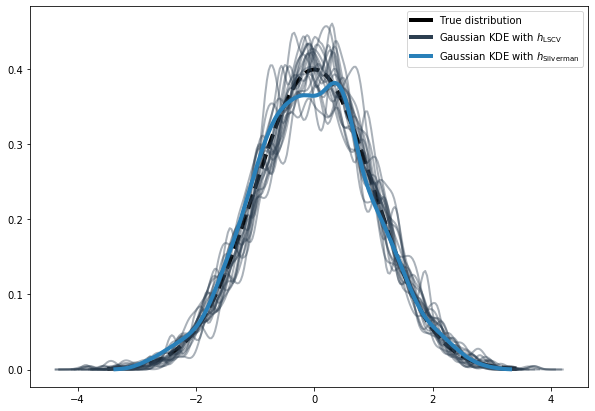

In [5]:
np.random.seed(1234)
colors = ["black", NIGHT_BLUE, DARK_BLUE]
labels = ["True distribution", r"Gaussian KDE with $h_{\mathrm{LSCV}}$", "Gaussian KDE with $h_{\mathrm{Silverman}}$"]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]

x_grid = np.linspace(-3.5, 3.5, 500)
plt.plot(x_grid, stats.norm.pdf(x_grid), linewidth=4, linestyle="--", color="black")

for i in range(20):
    rvs = np.random.normal(size=1000)
    h_lscv = h_cv(rvs)
    x_kde, y_kde = convolution_kde(rvs, h=h_lscv)
    plt.plot(x_kde, y_kde, linewidth=2, color=NIGHT_BLUE, alpha=0.4)

x_kde, y_kde = convolution_kde(rvs)
plt.plot(x_kde, y_kde, linewidth=4, color=DARK_BLUE)   
plt.legend(lines, labels);

With a sample size like the used in the example one would expect any plausible estimator to approximate the true $f$ very well, specially when it is about a Gaussian distribution. The estimator based on $h_{\text{LSCV}}$ is not only very biased and highly variable, but also very slow. It is not worth it to measure computational times given that it is in the order of the seconds even with a sample size of 1000.

#### b. Biased Cross-Validation

This method was proposed as an alternative to LSCV. It looks for the $h$ that minimizes an estimate of the AMISE instead of the ISE. 

This estimator receives the name of *biased* cross-validation in opposition to least squares cross-validation, which is also known as *unbiased* cross-validation because $E[\text{LSCV}(h)] = \text{MISE} - \int{f^2(x)dx}$.

Even though the estimator based on BCV, $h_{\text{BCV}}$ is considerably less variable than $h_{\text{LSCV}}$, it still faces limitations similar to LSCV. For example, it is recommended not to choose the global minimizer of the objective function and use an alternative that is based on a local minima.

Nevertheless, its practical performance has not been good enough to consider it as a plausible alternative to replace the usual combination of Gaussian KDE + Gaussian rule of thumb.

### 3. Plug-in Methods

The drawbacks in LSCV and BCV motivated researchers to look for methods with better convergence rates. The plug-in approach is consists of replacing the unknown quantity $R(f'')$ in the $h_{\text{AMISE}}$ expression with an estimate. The difference between this method and the rule of thumb is that the rule of thumb imposes a distribution from a parametric family, while this approach estimates $R(f'')$ from the data using a non-parametric approach.

Estimating $R(f'')$ by $R(\hat{f}_g'')$ requires to choose the bandwidth $g$ for the so called pilot estimate, which can be done in many ways. One of the first alternatives was proposed by Park and Marron in *Comparison of data-driven bandwidth selectors* (1990). A year later, Sheather and Jones published *A reliable data-based bandwidth seleciton method for kernel density estimation* where they present a new method that improves the one by Park and Marron.

#### a. Sheather-Jones plug-in method

This approach is based on writing $g$ for the estimate $R(\hat{f}'')$ as a function of $h$

$$
g(h) = C(\kappa)\left[ \frac{R(f'')}{R(f''')} \right]^{1/7} h^{5/7}
\tag{3.8}
$$

and estimating the resulting unknown funcitonals of $f$ using kernel density estimates with bandwidths chosen by normal rules of thumb. In this context, the only unknown quantity in the following expression is $h$,

$$
\left[\frac{R(\kappa)}{\mu_2(\kappa)^2\hat{S}(g(h))} \right] ^ {1/5} n ^{-1/5} - h= 0
\tag{3.9}
$$

The Sheather-Jones plug-in bandwidth $h_{\text{SJ}}$ is the solution to the equation 3.9, where:
 
* $\kappa$ is the kernel, usually a standard Gaussian density.  
* $\mu_2(\kappa)$ is the second moment of the distribution $\kappa$. In the case of a standard Gaussian kernel it is 1.  
* $\hat{S}(g)$ is a kernel based estimate of $R(f'')$  

$$ 
\hat{S}(g) = [N(N-1)]^{-1} g^{-5} \sum_{i=1}^N \sum_{j=1}^N { \phi^{\text{iv}}[g^{-1}(X_i - X_j)] }
\tag{3.10}
$$

$$
g(h) = 1.357 [\hat{S}(a) / \hat{T}(b) ]^{1/7}  h^{5/7}
\tag{3.11}
$$

where the term in brackets is the second stage estimate of $R(f'') / R(f''')$.

$$
\hat{T}(b) = -[N(N-1)]^{-1} b^{-7} \sum_{i=1}^N \sum_{j=1}^N { \phi^{\text{vi}}[b^{-1}(X_i - X_j)] }
\tag{3.12}
$$

For this estimate the bandwidths $a$ and $b$ are 

$$
\begin{array}{ccc}
    a = 0.920 \hat{\lambda} N ^{-1/7} & \text{and} & b = 0.912 \hat{\lambda} N ^ {-1/9}
\end{array}
\tag{3.13}
$$

Finally, $\phi^{\text{iv}}$ and $\phi^{\text{vi}}$ refer to the fourth and sixth derivatives of a standard Gaussian density. A better developed mathematical justification of each of the components can be found in the original paper.

One of the advantages of this method over the one by Park and Marron is that the function it minimizes is simpler. In addition, the convergence rate is in the order of $n ^ {-5/14}$, which is better compared to LSCV, BCV and Park and Marron's proposal.

One drawback mentioned by Sheather and Jones (1991) and Sheather in *Density estimation* (2004) is that the Sheather-Jones method is derived under the assumption that $f$ is a smooth density. Jones, Marron and Sheather (1996) found that when the true density is easy to estimate, $h_{\text{SJ}}$ tends to be centered at $h_{\text{AMISE}}$, while when the true density is harder, $h_{\text{SJ}}$ is usually centered at a higher value than $h_{\text{AMISE}}$, meaning that $h_{\text{SJ}}$ oversmooths.

<!-- https://math.stackexchange.com/questions/2287895/are-derivatives-of-the-standard-gaussian-density-bounded -->

In [6]:
from scipy.optimize import fsolve

# The n-th derivative of a gaussian pdf is given by the pdf times 
# the n-th probabilists' Hermite polynomial.
# ref: https://math.stackexchange.com/questions/2287895/are-derivatives-of-the-standard-gaussian-density-bounded
def phi6(x):
    return (x ** 6 - 15 * x ** 4 + 45 * x ** 2 - 15) * stats.norm.pdf(x)

def phi4(x):
    return (x ** 4 - 6 * x ** 2 + 3) * stats.norm.pdf(x)

def sj_helper(h, s_a, t_b, x_len, x_len_mult, x_pairwise_diff):
    """
    Equation 12 of Sheather and Jones [1]
    Equation 3.9 in this work.
    
    References
    ----------
    .. [1] A reliable data-based bandwidth selection method for kernel
        density estimation. Simon J. Sheather and Michael C. Jones.
        Journal of the Royal Statistical Society, Series B. 1991
    """
    
    numerator = 0.375 * np.pi ** -0.5  
    g_h = 1.357 * np.abs(s_a / t_b) ** (1 / 7) * h ** (5 / 7)
    s_g = np.sum(np.sum(phi4(x_pairwise_diff / g_h), 0))
    s_g *= x_len_mult * g_h ** -5
    
    output = (numerator / np.abs(s_g * x_len)) ** 0.2 - h
    
    return output

def h_sj(x):
    """
    Computes Sheather-Jones bandwidth for Gaussian KDE
    
    Parameters
    ----------
    x : numpy array
        1 dimensional array of sample data from the variable for which a 
        density estimate is desired.  
    Returns
    -------
    h : float
        Bandwidth estimated via Least Squares Cross-Validation
    """
    
    x_len = len(x)
    x_std = np.std(x)
    x_iqr = stats.iqr(x)
    
    a = 0.92 * x_iqr * x_len ** (-1 / 7)
    b = 0.912 * x_iqr * x_len ** (-1 / 9) 
    
    x_len_mult = 1 / (x_len * (x_len - 1))
    x_matrix = np.tile(x, (x_len, 1))
    x_pairwise_diff = x_matrix - x_matrix.T

    t_b = np.sum(np.sum(phi6(x_pairwise_diff / b), 0))
    t_b *= - x_len_mult * b ** -7

    s_a = np.sum(np.sum(phi4(x_pairwise_diff / a), 0))
    s_a *= x_len_mult * a ** -5
    
    # Silverman's rule as initial value for h
    h0 = 0.9 * x_std * x_len ** (-0.2)
    
    result = fsolve(sj_helper, h0, args=(s_a, t_b, x_len, x_len_mult, x_pairwise_diff))
    return result[0]

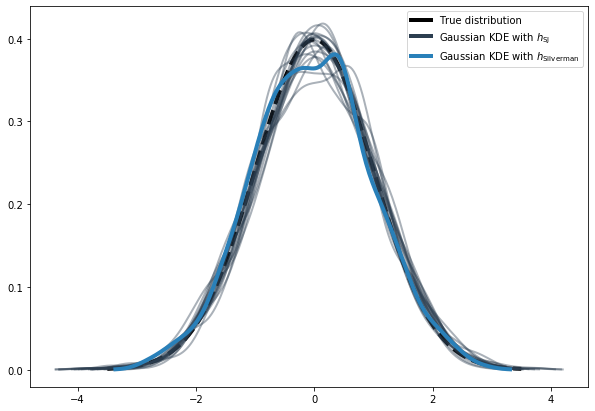

In [7]:
np.random.seed(1234)
colors = ["black", NIGHT_BLUE, DARK_BLUE]
labels = ["True distribution", r"Gaussian KDE with $h_{\mathrm{SJ}}$", "Gaussian KDE with $h_{\mathrm{Silverman}}$"]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]

x_grid = np.linspace(-3.5, 3.5, 500)
plt.plot(x_grid, stats.norm.pdf(x_grid), linewidth=4, linestyle="--", color="black")

for i in range(20):
    rvs = np.random.normal(size=1000)
    hsj = h_sj(rvs)
    x_kde, y_kde = convolution_kde(rvs, h=hsj)
    plt.plot(x_kde, y_kde, linewidth=2, color=NIGHT_BLUE, alpha=0.4)

x_kde, y_kde = convolution_kde(rvs)
plt.plot(x_kde, y_kde, linewidth=4, color=DARK_BLUE)   
plt.legend(lines, labels);

A drawback of the current implementation is that it stores the ${N}\choose{2}$ pairwise differences between the $N$ sample points. An element-wise computation of each of the terms in the distance matrix that is discarded after contributing to the sum would not require to store all the information at the same time but will be more demanding in terms of computation. It could be implemented in the future if more tests with the method are required.

#### b. Improved Sheather-Jones

This section is based in the two following works:

* Kernel density estimation via diffusin by Z.I. Botev, J.F. Grotowski and D.P. Kroese (2011)
* Chapter 8 of Handbook of Monte Carlo Methods by D.P. Kroese, T. Taimre and Z.I. Botev (2011)

The work by Botev et.al. (2011) starts with a strong critic at a conceptual level against normal reference rules to chose bandwidths. Here they introduce a new plug-in method that is *genuinely* non-parametric and completely data-driven. Unlike Sheather and Jones, they do not make any normality assumptions in any of the estimation stages. Furthermore, another advantage of the method is that it does not rely on any numerical optimization method to obtain the result. The authors state their method is not much slower than the computation of a Gaussian rule of thumb (we'll see). Finally, since the authors borrowed ideas from Sheather and Jones, they call their method improved Sheather-Jones.

Before we jump to the derivation of the method we should write again some formulas that are going to be referenced later.

Without loss of generality we can consider the data to be on the unit interval $[0, 1]$. If the raw data is not on the unit interval, then it can be rescaled with a linear transformation. 

First, recall that away from the boudaries the Gaussian kernel $\varphi_h(x) = \frac{1}{\sqrt{2\pi}h}e^{-\frac{1}{2}\left(\frac{x - X_i}{h}\right)^2}$ is approximated by the theta function

$$
\begin{array}{cc}
    \theta(x, X_i; t) = \sum_{k = - \infty}^{\infty}{ \varphi(x, 2k + X_i; t) +  \varphi(x, 2k - X_i; t)} & x \in (0,1)
\end{array}
\tag{3.14}
$$

and this derived in an approximation to the Gaussian kernel density estimate on the unit interval $(0, 1)$ by the truncated Fourier series expansion

$$
\begin{array}{cc}
  \displaystyle \hat{f}(x; t) \approx \sum_{k=0}^{m-1}{a_k e^{-k^2\pi^2 t / 2} \cos(k\pi x)}, & N \gg 1,
\end{array}
\tag{3.15}
$$

where the coefficients $\{a_k\}_{k=0}^{m - 1}$ are given by the cosine transform of the empirical data

$$
\begin{array}{ccc}
  a_0 = 1 & \displaystyle a_k = \frac{2}{N}\sum_{i=1}^{N}{\cos(k\pi X_i)}, & k = 1, 2, 3, \cdots .
\end{array}
\tag{3.16}
$$

And finally, let $t = h ^ 2$ so our notation is consistent with the derivation in the original work.

As previously mentioned, plug-in methods replace $R(f'')$ with an estimate. Thus, as any plug-in method, the improved Sheather-Jones method replaces $R(f'')$ with an estimate that is derived as follows.

<!-- Before proposing an estimator $R(f'') = \lVert f''\rVert^2$ -->
First, as the authors of the original paper do, note the identity $\lVert f^{(j)}\rVert^2 = (-1)^j\mathbb{E}_f\left[ f^{(2j)}(X)\right], \ j \ge1$, where $f^{(j)}$ represents the j-th derivative of $f$, suggests two possible plug-in estimators. The first one is 

$$
 \begin{split}
  (-1)^j\widehat{\mathbb{E}_{f}f^{(2j)}} & \overset{\text{def}}{=} \frac{(-1)^j}{N}\sum_{k=1}^N{\hat{f}^{(2j)}(X_k;t_j)}  \\
   & =  \displaystyle\frac{(-1)^j}{N^2}\sum_{k=1}^{N}{\sum_{m=1}^{N}{\varphi^{(2j)}(X_k, X_m; t_j)}}
\end{split}
\tag{3.17}
$$

where $\hat{f}$ is the Gaussian KDE with bandwith $\sqrt{t_j}$ different from the one $\sqrt{t^*}$ resulting from formula (3.2). Just think in the Sheather-Jones estimator, it is the same logic. In the previous section it was called $g(h)$.

The second estimator is

$$
\begin{split}
  \widehat{\lVert f^{(j)} \rVert^2} & \overset{\text{def}}{=} \lVert \hat{f}^{(j)}(\cdot;t_j) \rVert^2  \\
   & = \displaystyle \frac{1}{N^2}\sum_{k=1}^{N}{\sum_{m=1}^{N}{\int_{\mathbb{R}}\varphi^{(j)}(x, X_k;t_j)
       \varphi^{(j)}(x, X_m;t_j) \text{dx}}} \\
   & = \displaystyle\frac{(-1)^j}{N^2}\sum_{k=1}^{N}{\sum_{m=1}^{N}{\varphi^{(2j)}(X_k, X_m; 2t_j)}}
\end{split}
\tag{3.18}
$$

For a given bandwidth, both estimators $(-1)^j\widehat{\mathbb{E}_{f}f^{(2j)}}$ and $\widehat{\lVert f^{(j)} \rVert^2}$ aim to estimate the same quantity $\lVert f^{(j)} \rVert^2$.  
The logic the authors use to derive an estimator is to select $t_j$ so that both estimators are aymptotically equivalent in the mean square error sense. In other words, $ \hat{t}_j $ is chosen so that both $(-1)^j\widehat{\mathbb{E}_{f}f^{(2j)}}$ and $\widehat{\lVert f^{(j)} \rVert^2}$ have equal asymptotic mean square error. 

In pages 15 and 16 of Botev et.al. (2011) it is demonstrated that the estimator that satisfies the requirement is

$$
\hat{t}_j = \left(\frac{1 + \frac{1}{2^{j+1/2}}}{3} \frac{1\times3\times5\times\cdots\times(2j-1)}{N\sqrt{\pi/2} \lVert\hat{f}^{(j+1)}\rVert^2}\right)^\frac{2}{3+2j}
\tag{3.19}
$$

Next, we can see there is a problem: the computation of $\lVert\hat{f}^{(j+1)}\rVert^2$ requires knowing $\hat{t}_{j+1}$, which also requires having estimated $\hat{t}_{j+2}$, and so on, as one can appreciate from formulas (3.18) and (3.19). We face the problem of computing the infinite sequence $\{ \hat{t}_{j+k},\ k \ge 1\}$. 

Nevertheless, given $\hat{t}_{l+1}$ for some integer $l$, we can compute all the $\{\hat{t}_j, 1\le j \le l \}$ in a recursive fashion, and then estimate $t^*$ from (3.2). This motivates the **l-stage direct plug-in bandwidth selector** defined as follows:

**Algorrithm (l-stage Direct Plug-in Bandwidth Selector)**  
Given an integer $l \ge 3$, execute the following steps:  

1. Compute $\lVert\hat{f}^{(l+2)}\rVert^2$ by assuming that $f$ is a **Gaussian density** with mean and variance estimated with the iid sample $X_1, \cdots, X_N$. Here we can think that $j=l+1$, then $j+1=l+2$.
2. Using $\lVert\hat{f}^{(j+1)}\rVert^2$ compute $\hat{t}_j$ via (3.19).
3. Using $\hat{t}_j$ compute $\lVert\hat{f}^{(j)}\rVert^2$ via (3.18).
4. If $j \gt2$, $j=j-1$ repreat from Step 2; otherwise, continue with Step 5.
5. Use $\hat{t}_2$ to compute $\lVert\hat{f}^{(2)}\rVert^2$ and obtain $\hat{t}^*$ from (3.2).

Then, the **l-stage direct plug-in bandwidth selector** requires the estimation of $\lVert\hat{f}^{(j)}\rVert^2$, with $2 \le j \le l+1$ via the plug-in estimator (3.18).  

To improve the method the procedure is described in a slightly more abstract way as follows.

Let's represent the functional dependency of $\hat{t}_j$ on $\hat{t}_{j+1}$ in (3.19) as:

$$
\hat{t}_j = \gamma_j(\hat{t}_{j+1})
\tag{3.20}
$$

It is clear that $\hat{t}_j = \gamma_j(\gamma_{j+1}(\hat{t}_{j+2})) = \gamma_j(\gamma_{j+1}(\gamma_{j+2}(\hat{t}_{j+2}))) = \cdots$. Thus, the composition could be written in a simpler way as follows:

$$
\gamma^{[k]}(t)= \underbrace{\gamma_1(\cdots\gamma_{k-1}(\gamma_k)}_{k\ \text{times}}(t))\cdots), \ \ k\ge1.
\tag{3.21}
$$

Observing formulas (3.19) y (3.12) we note the estimator of $t^*$ satisfies:

$$
\begin{array}{c c}
\hat{t^*} = \zeta\hat{t}_1 = \zeta\gamma^{[1]}(\hat{t}_2) = \zeta\gamma^{[2]}(\hat{t}_3) = \cdots = \zeta\gamma^{[l]}(\hat{t}_{l+1}), & \displaystyle \zeta = \left(\frac{6\sqrt{2} - 3}{7} \right)^{2/5} \approx 0.907
\end{array}
\tag{3.22}
$$

Then, for any given integer $l>0$, the bandwidth selection via the direct plug-in method consists in the computation of:

$$
\hat{t}^* = \zeta\gamma^{[l]}(\hat{t}_{l+1})
\tag{3.23}
$$

where $\hat{t}_{l+1}$ is calculated via (3.19) assuming that $f$ is $\lVert\hat{f}^{(l+2)}\rVert^2$ the density of a Gaussian distribution with mean and variance estimated from the sample.

The **weakest point** of this procedure is that it **assumes the true $f$ is Gaussian** in order to compute  $\lVert\hat{f}^{(l+2)}\rVert^2$. This assumption can lead us to poor estimations of $t^*$, specially when the true distribution differs substantially from a normal.

Instead, the **improved plug-in** or **improved Sheather-Jones** method is proposed. It generally gives a *typically unique* solution to the following non-linear equation:

$$
\begin{array}{cc}
  t = \zeta\gamma^{[l]}(t), & \text{for large enough}\ l
\end{array}
\tag{3.24}
$$

as the near-optimal bandwidth estimate. This method is **free of any normality assumptions** and consequently it is more reliable and accurate than the majority of the alternative plug-in methods.

Now we present the implementation details of this algorithm. Without loss of generality, it is assumed the data lies in the interval $[0, 1]$ and we use the theta function approximation. 

<!-- Not sure if I should write the algorithm as in Kernel density estimation via diffusion (because it is not very clear) -->

The data is binned in a grid of size $m$ and the coefficients $\{a_k\}_{k=0}^{m-1}$ in the truncated Fourier series expansion are computed using the fast cosine transform. Then, for a given t,

$$
\lVert\hat{f}^{(j)}\rVert^2 \approx \frac{\pi^{2j}}{2}\sum_{k=1}^{m-1}{k^{2j}a_k^2\text{e}^{-k^2\pi^2t}}
\tag{3.25}
$$

The computation of the right-hand side of (3.24) is an $O(m)$ operation.  

Next, we present the implementation of this method in Python. In addition, $l=7$ is used. Botev et.al. (2011) suggest that larger values of $l$ do not change the value of the root in (3.24) in a substantial way.

In [8]:
from my_functions import dct1d
from scipy.optimize import fsolve
from scipy.optimize import fminbound

def _fixed_point(t, N, k_sq, a_sq):

    # To avoid prevent powers from overflowing.
    k_sq = np.asfarray(k_sq, dtype='float')
    a_sq = np.asfarray(a_sq, dtype='float')

    l = 7
    f = 0.5 * np.pi ** (2.0 * l) * sum(k_sq ** l * a_sq * np.exp(-k_sq * np.pi ** 2.0 * t))

    for j in reversed(range(2, l)):
        c1  = (1 + 0.5**(j + 0.5)) / 3.0
        c2  = np.product(np.arange(1., 2. * j + 1., 2., dtype = 'float')) / np.sqrt(np.pi / 2)
        t_j = np.power((c1 * c2 / (N * f)), (2 / (3 + 2 * j)))
        f   = 0.5 * np.pi ** (2. * j) * sum(k_sq ** j * a_sq * np.exp(-k_sq * np.pi ** 2. * t_j) )

    out = t - (2. * N * np.sqrt(np.pi) * f) ** (-0.4)
    return out

def h_isj(x, grid_len = 256):
    
    x_len = len(x)
    x_min = np.min(x)
    x_max = np.max(x)
    x_range = x_max - x_min
    x_std = np.std(x)
    
    grid_min = x_min - 0.5 * x_std
    grid_max = x_max + 0.5 * x_std
       
    # Relative frequency per bin
    f, edges = np.histogram(x, bins=grid_len, range=(grid_min, grid_max))
    f = f / x_len

    # Discrete cosine transform of the data
    a_k = dct1d(f)
    
    k_sq = np.arange(1, grid_len) ** 2
    a_sq = a_k[range(1, grid_len)] ** 2
    
    t = fsolve(_fixed_point, 0.02, args=(x_len, k_sq, a_sq))
    h = np.sqrt(t[0]) * x_range
    
    return h

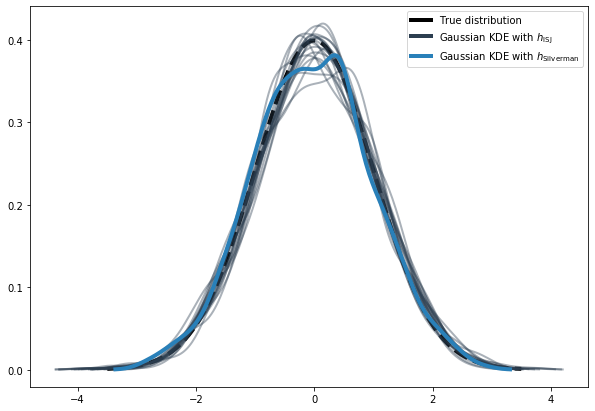

In [9]:
np.random.seed(1234)
colors = ["black", NIGHT_BLUE, DARK_BLUE]
labels = ["True distribution", r"Gaussian KDE with $h_{\mathrm{ISJ}}$", "Gaussian KDE with $h_{\mathrm{Silverman}}$"]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]

x_grid = np.linspace(-3.5, 3.5, 500)
plt.plot(x_grid, stats.norm.pdf(x_grid), linewidth=4, linestyle="--", color="black")

for i in range(20):
    rvs = np.random.normal(size=1000)
    hisj = h_isj(rvs)
    x_kde, y_kde = convolution_kde(rvs, h=hisj)
    plt.plot(x_kde, y_kde, linewidth=2, color=NIGHT_BLUE, alpha=0.4)

x_kde, y_kde = convolution_kde(rvs)
plt.plot(x_kde, y_kde, linewidth=4, color=DARK_BLUE)   
plt.legend(lines, labels)
plt.show()

## Back to the original problem...

### A Gaussian mixture
Now we are going to see the performance of each of the introduced methods in the problem presented in the introduction. 

C:\Users\Tomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
C:\Users\Tomi\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: IntegrationWarning: The integral is probably divergent, or slowly convergent.


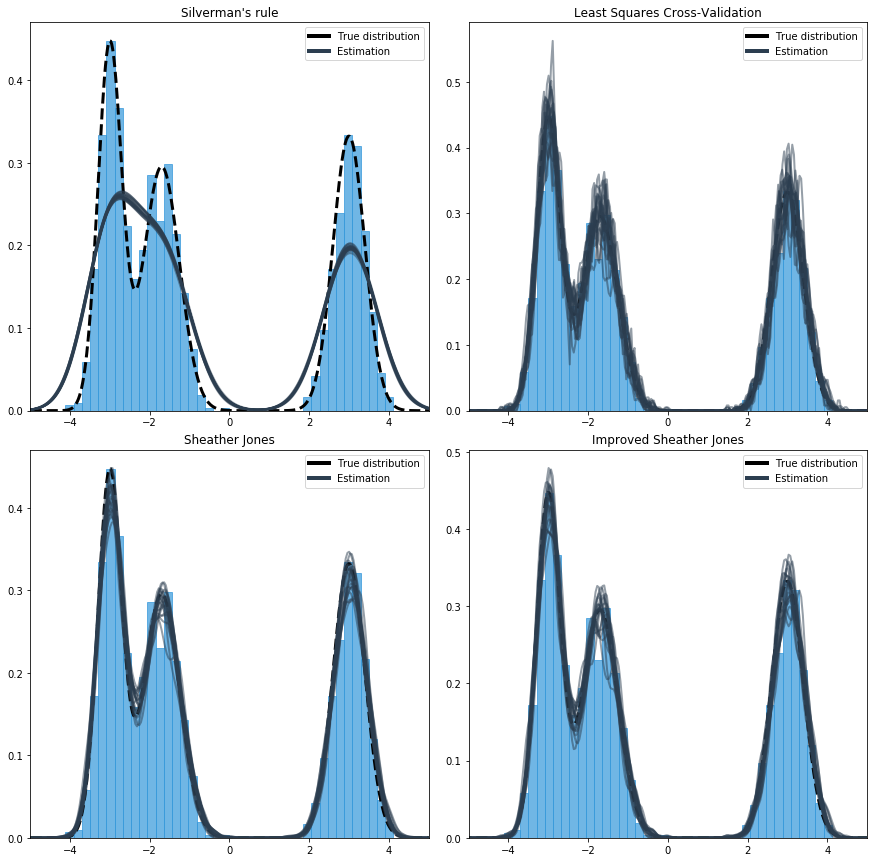

In [10]:
np.random.seed(1234)
x_grid = np.linspace(-6, 7, 500)
mean = [-3, -1.7, 3]
sd = [0.3, 0.45, 0.4]
n = 1500
reps = 20

colors = ["black", NIGHT_BLUE]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]
labels = ["True distribution", "Estimation"]

pdf_true = get_pdf(x_grid, mean, sd)

fig, axes = plt.subplots(2, 2, figsize = (15, 15))

for i, j in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    axes[i, j].plot(x_grid, pdf_true, linewidth=3, linestyle="--", color="black")

for i in range(reps):
    rvs = generate_rvs(n, mean, sd)
    
    hlscv = h_cv(rvs)
    hsj = h_sj(rvs)
    hisj = h_isj(rvs)
    
    x_sil, y_sil = convolution_kde(rvs)
    x_lscv, y_lscv = convolution_kde(rvs, h=hlscv)
    x_sj, y_sj = convolution_kde(rvs, h=hsj)
    x_isj, y_isj = convolution_kde(rvs, h=hisj)
    
    axes[0, 0].plot(x_sil, y_sil, linewidth=2, color=NIGHT_BLUE, alpha=0.5)
    axes[0, 1].plot(x_sil, y_lscv, linewidth=2, color=NIGHT_BLUE, alpha=0.5)
    axes[1, 0].plot(x_sil, y_sj, linewidth=2, color=NIGHT_BLUE, alpha=0.5)
    axes[1, 1].plot(x_sil, y_isj, linewidth=2, color=NIGHT_BLUE, alpha=0.5)

for i, j in zip([0, 0, 1, 1], [0, 1, 0, 1]):
    axes[i, j].hist(rvs, density=True, bins=40, alpha=0.7, Color=BLUE)
    axes[i, j].legend(lines, labels)
    axes[i, j].set_xlim(-5, 5)

axes[0, 0].set_title("Silverman's rule")
axes[0, 1].set_title("Least Squares Cross-Validation")
axes[1, 0].set_title("Sheather Jones")
axes[1, 1].set_title("Improved Sheather Jones")    

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

### Separated bimodal

Distributions with multiple modalities and a considerable separation between them are the ones where the Gaussian rule of thumb perform worse. The following is a comparison between Silverman's rule, Sheather-Jones and the improved Sheather-Jones.

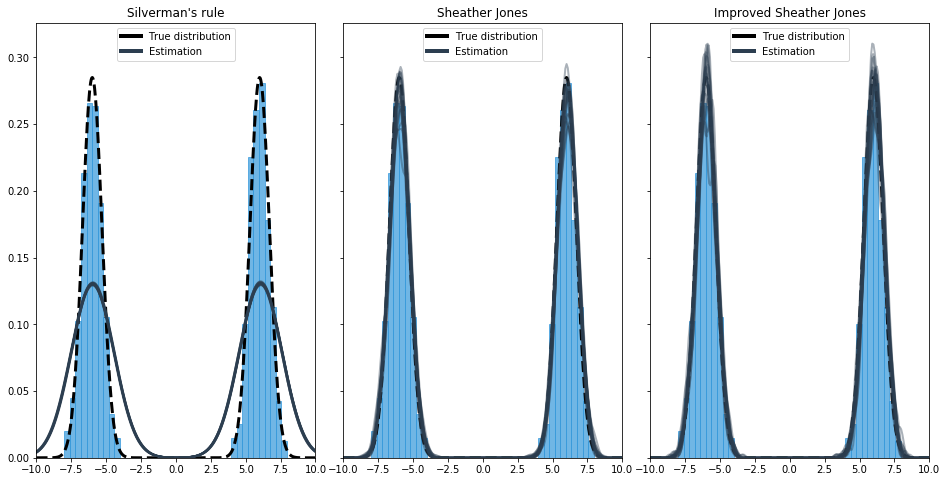

In [11]:
np.random.seed(1234)
x_grid = np.linspace(-10, 10, 500)
mean = [-6, 6]
sd = [0.7, 0.7]
n = 1000
reps = 20

colors = ["black", NIGHT_BLUE]
lines = [Line2D([0], [0], color=c, linewidth=4) for c in colors]
labels = ["True distribution", "Estimation"]

pdf_true = get_pdf(x_grid, mean, sd)

fig, axes = plt.subplots(1, 3, figsize = (16, 8), sharey=True)

for i in [0, 1, 2]:
    axes[i].plot(x_grid, pdf_true, linewidth=3, linestyle="--", color="black")

for i in range(reps):
    rvs = generate_rvs(n, mean, sd)
    
    hsj = h_sj(rvs)
    hisj = h_isj(rvs)
    
    x_sil, y_sil = convolution_kde(rvs)
    x_sj, y_sj = convolution_kde(rvs, h=hsj)
    x_isj, y_isj = convolution_kde(rvs, h=hisj)
    
    axes[0].plot(x_sil, y_sil, linewidth=2, color=NIGHT_BLUE, alpha=0.4)
    axes[1].plot(x_sil, y_sj, linewidth=2, color=NIGHT_BLUE, alpha=0.4)
    axes[2].plot(x_sil, y_isj, linewidth=2, color=NIGHT_BLUE, alpha=0.4)

for i in [0, 1, 2]:
    axes[i].hist(rvs, density=True, bins=40, alpha=0.7, Color=BLUE)
    axes[i].legend(lines, labels, loc=9) # upper-center
    axes[i].set_xlim(-10, 10)

axes[0].set_title("Silverman's rule")
axes[1].set_title("Sheather Jones")
axes[2].set_title("Improved Sheather Jones")    

plt.subplots_adjust(wspace=0.1)
plt.show()